In [16]:
import os
import glob

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [17]:
# ============================================================
# CONFIG
# ============================================================

# Rootmap waar ALLE afbeeldingen staan
DATA_ROOT = r"C:\Users\ICT\Documents\Semester 1\Periode 2\GitCodeProj\AI-Waste_Vision_POC"

# Pad naar je label-CSV
LABEL_CSV = r"C:\Users\ICT\Documents\Semester 1\Periode 2\GitCodeProj\AI-Waste_Vision_POC\labels.csv"

# Uitvoer-CSV met pseudo-labels
PSEUDO_LABEL_CSV = r"C:\Users\ICT\Documents\Semester 1\Periode 2\GitCodeProj\AI-Waste_Vision_POC\pseudo_labels_resnet.csv"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_FIRST = 1      # eerste training op alleen echte labels
EPOCHS_SECOND = 1     # tweede training met pseudo-labels erbij

MAX_UNLABELED_PSEUDO = 100   # gebruik alleen de eerste 100 unlabeled voor pseudo-labeling (None = alles)

CONF_POS = 0.9   # > 0.9 => container
CONF_NEG = 0.1   # < 0.1 => geen container


# ============================================================
# HULPFUNCTIES VOOR DATA
# ============================================================

def find_all_images(data_root):
    """Vind alle .jpg-bestanden onder DATA_ROOT en maak relatieve paden."""
    pattern = os.path.join(data_root, "**", "*.jpg")
    files = glob.glob(pattern, recursive=True)
    records = []
    for f in files:
        rel = os.path.relpath(f, data_root).replace("\\", "/")
        records.append({"abs_path": f, "rel_path": rel})
    df = pd.DataFrame(records)
    return df


def load_labels(label_csv):
    """Laad CSV met kolommen: image_path, label."""
    df = pd.read_csv(label_csv)
    # Zorg dat image_path ook forward slashes heeft
    df["image_path"] = df["image_path"].str.replace("\\", "/")
    return df


def build_merged_dataframe():
    """Combineer alle images met de (sub)set gelabelde images."""
    df_all = find_all_images(DATA_ROOT)
    df_labels = load_labels(LABEL_CSV)

    # Merge op relatieve paden
    df = df_all.merge(
        df_labels,
        left_on="rel_path",
        right_on="image_path",
        how="left"
    )

    # label: -1 = geen container, 0/1 = wel container
    # We maken nu een binaire label_bit: 0 = geen container, 1 = container
    def to_binary(label):
        if pd.isna(label):
            return np.nan
        if label == -1:
            return 0
        # 0 of 1 = container
        return 1

    df["label_bin"] = df["label"].apply(to_binary)

    labeled_df = df[~df["label_bin"].isna()].copy()
    unlabeled_df = df[df["label_bin"].isna()].copy()

    print(f"Totaal images gevonden: {len(df)}")
    print(f"Labeled (uit CSV):      {len(labeled_df)}")
    print(f"Unlabeled:              {len(unlabeled_df)}")

    return df, labeled_df, unlabeled_df


# ============================================================
# TF.DATA PIPELINES
# ============================================================

def decode_image(path, label=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    if label is None:
        return img
    else:
        return img, label


def make_labeled_dataset(paths, labels, augment=False, shuffle=False):
    paths = tf.constant(paths)
    labels = tf.constant(labels, dtype=tf.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: decode_image(p, l), num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
            layers.RandomContrast(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


def make_unlabeled_dataset(paths):
    paths = tf.constant(paths)
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(lambda p: decode_image(p, None), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


# ============================================================
# MODEL
# ============================================================

def build_resnet_model():
    base = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base.trainable = False  # eerst frozen

    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


# ============================================================
# PSEUDO-LABELLOGICA
# ============================================================

def generate_pseudo_labels(model, unlabeled_df):
    """Laat het model voorspellen op de unlabeled set en kies high-confidence pseudo-labels."""
    if len(unlabeled_df) == 0:
        print("Geen unlabeled images gevonden, sla pseudo-label-stap over.")
        return pd.DataFrame([])

    # ➜ alleen de eerste N unlabeled gebruiken (test-run)
    if MAX_UNLABELED_PSEUDO is not None and len(unlabeled_df) > MAX_UNLABELED_PSEUDO:
        print(f"Gebruik alleen de eerste {MAX_UNLABELED_PSEUDO} unlabeled images voor pseudo-labeling.")
        unlabeled_df = unlabeled_df.head(MAX_UNLABELED_PSEUDO).copy()

    ds_unlabeled = make_unlabeled_dataset(unlabeled_df["abs_path"].values)
    preds = model.predict(ds_unlabeled, verbose=1).ravel()  # sigmoid outputs (0..1)

    unlabeled_df = unlabeled_df.copy()
    unlabeled_df["pred_prob"] = preds

    # High-confidence container
    mask_pos = unlabeled_df["pred_prob"] >= CONF_POS
    # High-confidence geen container
    mask_neg = unlabeled_df["pred_prob"] <= CONF_NEG

    pseudo_pos = unlabeled_df[mask_pos].copy()
    pseudo_pos["label_bin"] = 1

    pseudo_neg = unlabeled_df[mask_neg].copy()
    pseudo_neg["label_bin"] = 0

    pseudo_df = pd.concat([pseudo_pos, pseudo_neg], axis=0)
    pseudo_df["is_pseudo"] = True

    print(f"Pseudo-labels gemaakt: {len(pseudo_df)} "
          f"(pos: {len(pseudo_pos)}, neg: {len(pseudo_neg)})")

    return pseudo_df

In [18]:
def evaluate_and_plot_grid(model, val_paths, val_labels, class_names=("no_container", "container"), threshold=0.5):
    """Evalueer het model op de val-set en plot een grid van voorbeelden."""
    val_ds = make_labeled_dataset(val_paths, val_labels, augment=False, shuffle=False)

    # Voorspellingen
    preds = model.predict(val_ds, verbose=1).ravel()
    y_true = np.array(val_labels).astype(int)
    y_prob = preds
    y_pred = (y_prob >= threshold).astype(int)   # 👈 threshold parametrisch

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("\n=== Evaluatie op validation set ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion matrix (rows = true, cols = pred):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Grid plotten
    n_show = min(16, len(val_paths))
    if n_show == 0:
        print("Geen validation samples om te plotten.")
        return

    # neem gewoon de eerste n_show voorbeelden
    idxs = np.arange(n_show)

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(idxs):
        img_path = val_paths[idx]
        img = tf.keras.utils.load_img(img_path)  # origineel formaat
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

        true_lbl = class_names[y_true[idx]]
        pred_lbl = class_names[y_pred[idx]]
        prob = y_prob[idx]

        plt.title(f"T:{true_lbl}\nP:{pred_lbl} ({prob:.2f})", fontsize=8)

    plt.tight_layout()
    plt.show()


In [19]:
full_df, labeled_df, unlabeled_df = build_merged_dataframe()

train_df, val_df = train_test_split(
    labeled_df,
    test_size=0.2,
    stratify=labeled_df["label_bin"],
    random_state=42
)

# y moet int zijn (0/1)
y_train_int = train_labels.astype(int)

classes = np.array([0, 1])
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_int
)
class_weight = {0: class_weights_arr[0], 1: class_weights_arr[1]}

print("Class weights:", class_weight)

train_paths = train_df["abs_path"].values
val_paths = val_df["abs_path"].values

train_labels = train_df["label_bin"].values
val_labels = val_df["label_bin"].values

len(train_paths), len(val_paths), len(unlabeled_df)


Totaal images gevonden: 90606
Labeled (uit CSV):      2319
Unlabeled:              88287
Class weights: {0: 0.8791469194312796, 1: 1.159375}


(1855, 464, 88287)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


=== Eerste training: alleen echte labels ===
58/58 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5094 - loss: 0.8712 - val_accuracy: 0.4569 - val_loss: 0.8503
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step 

=== Evaluatie op validation set ===
Accuracy: 0.4569
Confusion matrix (rows = true, cols = pred):
[[ 52 212]
 [ 40 160]]

Classification report:
              precision    recall  f1-score   support

no_container       0.57      0.20      0.29       264
   container       0.43      0.80      0.56       200

    accuracy                           0.46       464
   macro avg       0.50      0.50      0.43       464
weighted avg       0.51      0.46      0.41       464



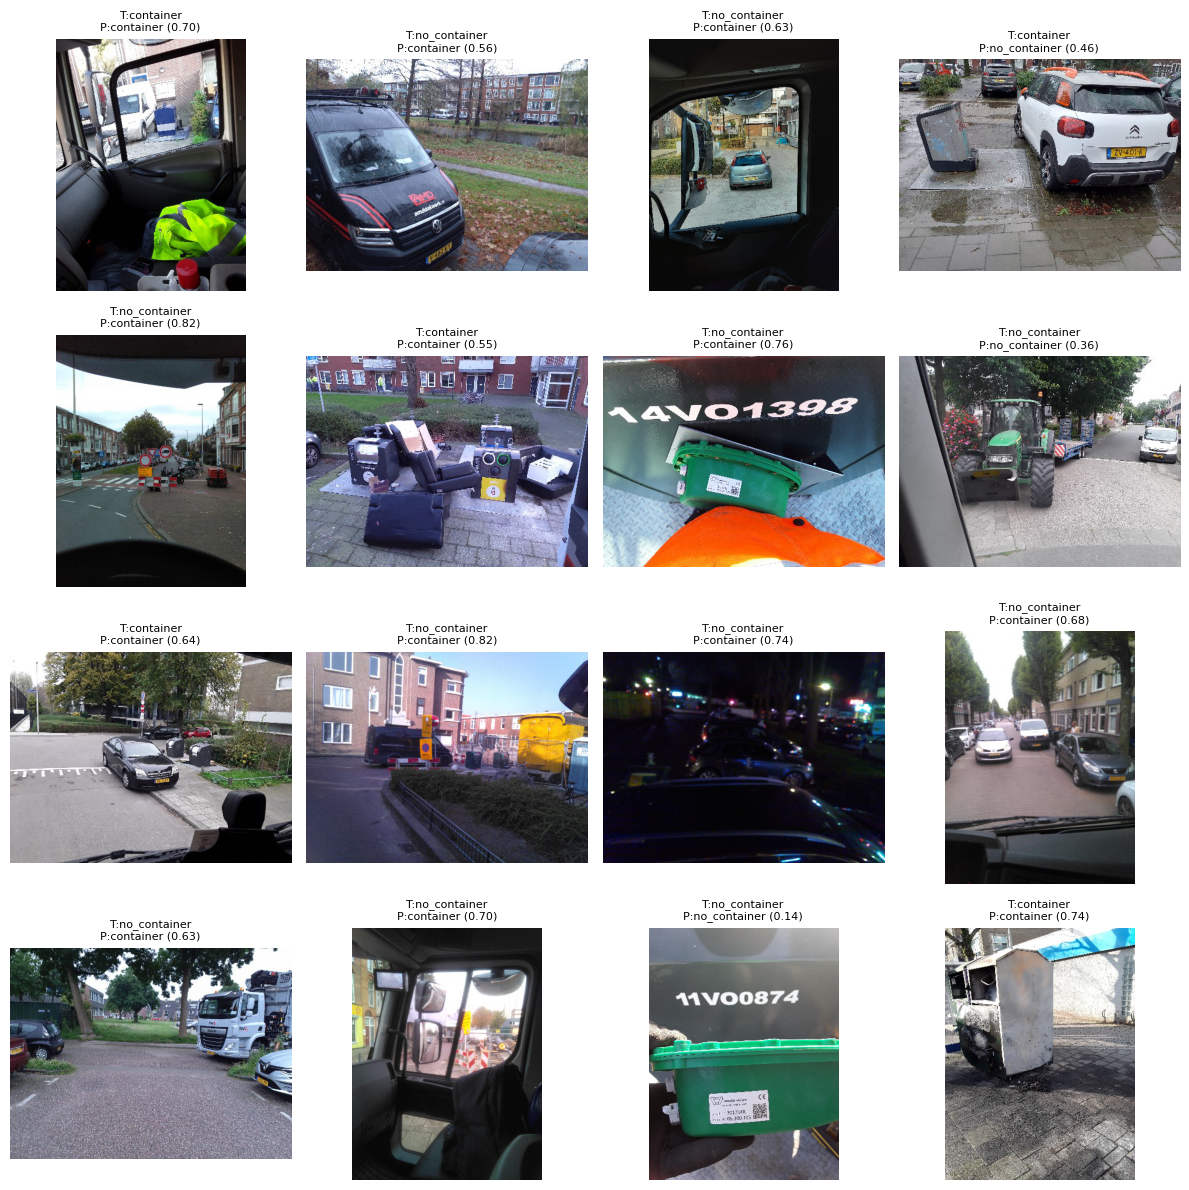

In [20]:
train_ds = make_labeled_dataset(train_paths, train_labels, augment=True, shuffle=True)
val_ds = make_labeled_dataset(val_paths, val_labels, augment=False, shuffle=False)

model = build_resnet_model()
model.summary()

cb_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

print("\n=== Eerste training: alleen echte labels ===")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FIRST,
    callbacks=[cb_early],
    class_weight=class_weight
)

# Evaluatie + grid
evaluate_and_plot_grid(model, val_paths, val_labels)


Gebruik alleen de eerste 100 unlabeled images voor pseudo-labeling.
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  
Pseudo-labels gemaakt: 6 (pos: 6, neg: 0)
Pseudo-labels opgeslagen in: C:\Users\ICT\Documents\Semester 1\Periode 2\GitCodeProj\AI-Waste_Vision_POC\pseudo_labels_resnet.csv

=== Tweede training: echte + pseudo labels (fine-tuning) ===
59/59 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.5726 - loss: 0.7098 - val_accuracy: 0.6129 - val_loss: 0.6225

=== Evaluatie na fine-tuning met pseudo-labels ===
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step 

=== Evaluatie op validation set ===
Accuracy: 0.6129
Confusion matrix (rows = true, cols = pred):
[[141 123]
 [ 57 144]]

Classification report:
              precision    recall  f1-score   support

no_container       0.71      0.53      0.61       264
   container       0.54      0.72      0.62       201

    accuracy                           0.61       465
   macro avg       0.63      0.63      0.61       465
weighted avg       0.64      0.61 

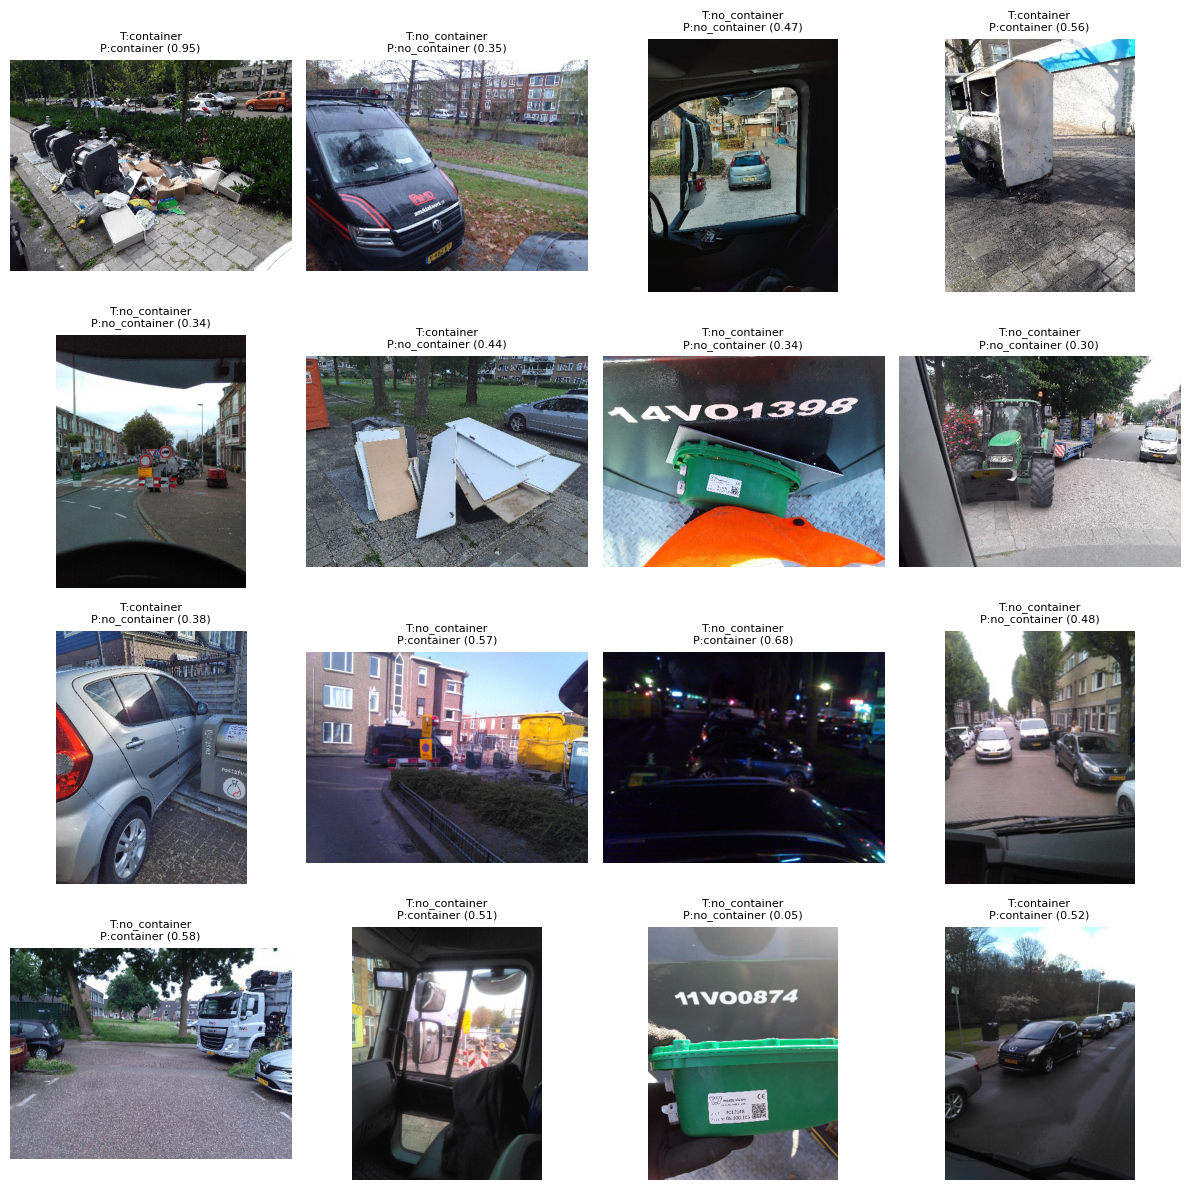

In [21]:
# 1. Pseudo-labels genereren op (max) de eerste 100 unlabeled
pseudo_df = generate_pseudo_labels(model, unlabeled_df)

if len(pseudo_df) > 0:
    out_cols = ["rel_path", "abs_path", "pred_prob", "label_bin"]
    pseudo_df[out_cols].to_csv(PSEUDO_LABEL_CSV, index=False)
    print(f"Pseudo-labels opgeslagen in: {PSEUDO_LABEL_CSV}")

    # 2. Combineer echte labels + pseudo labels
    labeled_df["is_pseudo"] = False
    pseudo_df["is_pseudo"] = True
    combined = pd.concat([labeled_df, pseudo_df], axis=0)

    train2_df, val2_df = train_test_split(
        combined,
        test_size=0.2,
        stratify=combined["label_bin"],
        random_state=42
    )

    train2_paths = train2_df["abs_path"].values
    train2_labels = train2_df["label_bin"].values
    val2_paths = val2_df["abs_path"].values
    val2_labels = val2_df["label_bin"].values

    train2_ds = make_labeled_dataset(train2_paths, train2_labels, augment=True, shuffle=True)
    val2_ds = make_labeled_dataset(val2_paths, val2_labels, augment=False, shuffle=False)

    # 3. Fine-tunen: ResNet-base trainable maken
    base_model = model.layers[1]  # ResNet-base in ons Model
    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    print("\n=== Tweede training: echte + pseudo labels (fine-tuning) ===")
    history2 = model.fit(
        train2_ds,
        validation_data=val2_ds,
        epochs=EPOCHS_SECOND,
        callbacks=[cb_early],
        class_weight=class_weight
    )

    # Evaluatie na fine-tuning (ander grid)
    print("\n=== Evaluatie na fine-tuning met pseudo-labels ===")
    evaluate_and_plot_grid(model, val2_paths, val2_labels)

else:
    print("Geen pseudo-labels gemaakt, skip tweede training.")


In [22]:
# 1. Eén keer de raw voorspellingen ophalen
val_ds = make_labeled_dataset(val_paths, val_labels, augment=False, shuffle=False)
y_true = np.array(val_labels).astype(int)
y_prob = model.predict(val_ds, verbose=1).ravel()

def evaluate_thresholds(y_true, y_prob, thresholds, class_names=("no_container", "container")):
    for th in thresholds:
        y_pred = (y_prob >= th).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        print(f"\n===== Threshold = {th:.2f} =====")
        print("Confusion matrix (rows = true, cols = pred):")
        print(cm)
        print(classification_report(y_true, y_pred, target_names=class_names))

# Kies een paar thresholds om te testen
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
evaluate_thresholds(y_true, y_prob, thresholds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 956ms/step

===== Threshold = 0.30 =====
Confusion matrix (rows = true, cols = pred):
[[ 54 210]
 [  7 193]]
              precision    recall  f1-score   support

no_container       0.89      0.20      0.33       264
   container       0.48      0.96      0.64       200

    accuracy                           0.53       464
   macro avg       0.68      0.58      0.49       464
weighted avg       0.71      0.53      0.46       464


===== Threshold = 0.40 =====
Confusion matrix (rows = true, cols = pred):
[[103 161]
 [ 30 170]]
              precision    recall  f1-score   support

no_container       0.77      0.39      0.52       264
   container       0.51      0.85      0.64       200

    accuracy                           0.59       464
   macro avg       0.64      0.62      0.58       464
weighted avg       0.66      0.59      0.57       464


===== Threshold = 0.50 =====
Confusion matrix (rows = true, cols = pred):
[[141 123]
 [ 55 145]]
          